In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing Libraries

In [ ]:
from pathlib import Path
import os, shutil, random, csv
from PIL import Image, UnidentifiedImageError
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img,load_img
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [ ]:
DRIVE_BASE = Path("/content/drive/MyDrive/Colab Notebooks")
INPUT_DIR = DRIVE_BASE / "Dataset"
CLEAN_DIR = DRIVE_BASE / "Dataset_cleaned"
AUG_DIR = DRIVE_BASE / "Dataset_augmented"
LABELS_CSV = DRIVE_BASE / "labels.csv"
LABELS_ONEHOT_CSV = DRIVE_BASE / "labels_onehot.csv"

In [ ]:
IMG_SIZE = (224, 224)
TARGET_PER_CLASS = 500
AUG_PER_IMAGE = 4
SEED = 42

In [ ]:
CLEAN_DIR.mkdir(parents=True, exist_ok=True)
AUG_DIR.mkdir(parents=True, exist_ok=True)
random.seed(SEED)
np.random.seed(SEED)

Helping Functions

In [ ]:
def is_valid_image(path):
    try:
        with Image.open(path) as im:
            im.verify()
        return True
    except Exception:
        return False

In [ ]:
def resize_save_jpg(src_path, dst_path, size=IMG_SIZE):
    """Resize to size, convert to RGB and save as JPEG (uint8)."""
    with Image.open(src_path) as im:
        im = im.convert("RGB").resize(size, Image.BILINEAR)
        # ensure parent folder exists
        dst_path.parent.mkdir(parents=True, exist_ok=True)
        im.save(dst_path, format="JPEG", quality=90)

In [ ]:
def count_images_in_folder(folder):
    return len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.jpeg','.png'))])

In [ ]:
print("Raw dataset path:", INPUT_DIR)
classes = sorted([p.name for p in INPUT_DIR.iterdir() if p.is_dir()])
if not classes:
    raise SystemExit(f"No class folders found in {INPUT_DIR}. Upload dataset first.")

print("Found classes:", classes)

Raw dataset path: /content/drive/MyDrive/Colab Notebooks/Dataset
Found classes: ['clear_skin', 'dark_spots', 'puffy_eyes', 'wrinkles']


Resizing and Normalizing

In [ ]:
clean_counts = {}
for cls in classes:
    src_dir = INPUT_DIR / cls
    dst_dir = CLEAN_DIR / cls
    dst_dir.mkdir(parents=True, exist_ok=True)
    cnt = 0
    for fname in sorted(os.listdir(src_dir)):
        src_path = src_dir / fname
        if not src_path.is_file():
            continue
        if not is_valid_image(src_path):
            print("Skipping corrupted:", src_path)
            continue
        try:
            out_name = f"{cls}_{cnt:04d}.jpg"
            resize_save_jpg(src_path, dst_dir / out_name, size=IMG_SIZE)
            cnt += 1
        except Exception as e:
            print("Error processing", src_path, e)
    clean_counts[cls] = cnt
    print(f"{cls}: saved {cnt} cleaned images to {dst_dir}")

clear_skin: saved 100 cleaned images to /content/drive/MyDrive/Colab Notebooks/Dataset_cleaned/clear_skin
dark_spots: saved 100 cleaned images to /content/drive/MyDrive/Colab Notebooks/Dataset_cleaned/dark_spots
puffy_eyes: saved 100 cleaned images to /content/drive/MyDrive/Colab Notebooks/Dataset_cleaned/puffy_eyes
wrinkles: saved 100 cleaned images to /content/drive/MyDrive/Colab Notebooks/Dataset_cleaned/wrinkles


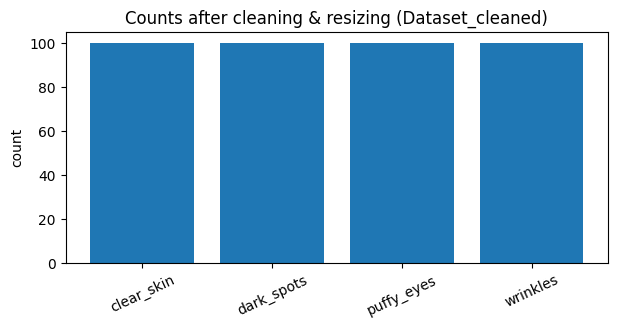

In [ ]:
plt.figure(figsize=(7,3))
plt.bar(list(clean_counts.keys()), list(clean_counts.values()))
plt.title("Counts after cleaning & resizing (Dataset_cleaned)")
plt.xticks(rotation=25)
plt.ylabel("count")
plt.show()

In [ ]:
aug_gen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.10,
    width_shift_range=0.06,
    height_shift_range=0.06,
    fill_mode='nearest'
)
MAX_ITER_MULTIPLIER = 200

classes = sorted([p.name for p in CLEAN_DIR.iterdir() if p.is_dir()])
print("Classes to augment:", classes)

Classes to augment: ['clear_skin', 'dark_spots', 'puffy_eyes', 'wrinkles']


In [ ]:
try:
    CLEAN_DIR
    AUG_DIR
    IMG_SIZE
    TARGET_PER_CLASS
    AUG_PER_IMAGE
    SEED
except NameError:
    from pathlib import Path
    DRIVE_BASE = Path("/content/drive/MyDrive/Colab Notebooks")
    CLEAN_DIR = DRIVE_BASE / "Dataset_cleaned"
    AUG_DIR = DRIVE_BASE / "Dataset_augmented"
    IMG_SIZE = (224, 224)
    TARGET_PER_CLASS = 500
    AUG_PER_IMAGE = 4
    SEED = 42

print("CLEAN_DIR:", CLEAN_DIR)
print("AUG_DIR:", AUG_DIR)
print("IMG_SIZE:", IMG_SIZE, "TARGET_PER_CLASS:", TARGET_PER_CLASS, "AUG_PER_IMAGE:", AUG_PER_IMAGE)

CLEAN_DIR: /content/drive/MyDrive/Colab Notebooks/Dataset_cleaned
AUG_DIR: /content/drive/MyDrive/Colab Notebooks/Dataset_augmented
IMG_SIZE: (224, 224) TARGET_PER_CLASS: 500 AUG_PER_IMAGE: 4


In [ ]:

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Loop through each class
classes = [cls for cls in os.listdir(CLEAN_DIR) if (CLEAN_DIR/cls).is_dir()]

for cls in classes:
    src_dir = CLEAN_DIR / cls
    dst_dir = AUG_DIR / cls
    dst_dir.mkdir(parents=True, exist_ok=True)

    images = list(src_dir.glob("*.*"))

    for i, img_path in enumerate(images):
        img = load_img(img_path, target_size=IMG_SIZE)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Generate augmented images
        aug_iter = datagen.flow(x, batch_size=1)
        for j in range(AUG_PER_IMAGE):
            aug_img = next(aug_iter)[0].astype('uint8')
            aug_img_path = dst_dir / f"{img_path.stem}_aug{j}.jpg"
            from tensorflow.keras.preprocessing.image import save_img
            save_img(aug_img_path, aug_img)

print("Augmentation completed!")

Augmentation completed!


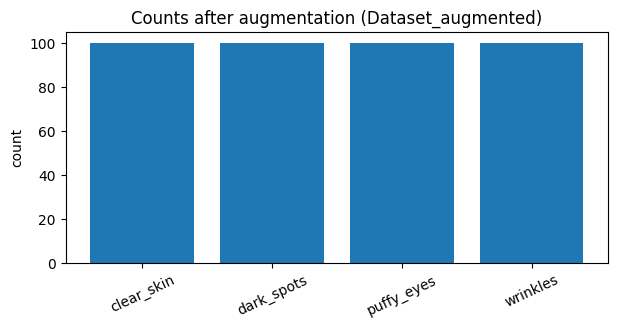

In [ ]:
final_counts = {cls: count_images_in_folder(AUG_DIR / cls) for cls in classes}
plt.figure(figsize=(7,3))
plt.bar(list(final_counts.keys()), list(final_counts.values()))
plt.title("Counts after augmentation (Dataset_augmented)")
plt.xticks(rotation=25)
plt.ylabel("count")
plt.show()

In [ ]:
classes = sorted([p.name for p in AUG_DIR.iterdir() if p.is_dir()])
print("Augmented classes:", classes)

filepaths = []
labels = []

Augmented classes: ['clear_skin', 'dark_spots', 'puffy_eyes', 'wrinkles']


In [ ]:
for cls in classes:
    folder = AUG_DIR / cls
    for fname in sorted(os.listdir(folder)):
        if not fname.lower().endswith(('.jpg','.jpeg','.png')):
            continue
        # store filepath relative to AUG_DIR so ImageDataGenerator.flow_from_dataframe(directory=AUG_DIR) works
        rel = str(Path(cls) / fname)
        filepaths.append(rel)
        labels.append(cls)
with open(LABELS_CSV, "w", newline='') as f:
    w = csv.writer(f)
    w.writerow(["filepath", "class"])
    w.writerows(zip(filepaths, labels))
print("Wrote:", LABELS_CSV)

Wrote: /content/drive/MyDrive/Colab Notebooks/labels.csv


In [ ]:
le = LabelEncoder()
y_int = le.fit_transform(labels)
y_onehot = to_categorical(y_int)
with open(LABELS_ONEHOT_CSV, "w", newline='') as f:
    w = csv.writer(f)
    header = ["filepath", "class"] + [f"o_{i}" for i in range(y_onehot.shape[1])]
    w.writerow(header)
    for p, c, vec in zip(filepaths, labels, y_onehot):
        w.writerow([p, c] + list(map(int, vec)))
print("Wrote:", LABELS_ONEHOT_CSV)
print("Label mapping:", dict(zip(le.classes_, range(len(le.classes_)))))

Wrote: /content/drive/MyDrive/Colab Notebooks/labels_onehot.csv
Label mapping: {np.str_('clear_skin'): 0, np.str_('dark_spots'): 1, np.str_('puffy_eyes'): 2, np.str_('wrinkles'): 3}
